In [2]:
# K-means Clustering with PySpark - Simple Customer Segmentation
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initialize Spark with local bind address to avoid port binding issues
spark = (
	SparkSession.builder
	.appName("CustomerSegmentation")
	.config("spark.driver.host", "127.0.0.1")
	.config("spark.driver.bindAddress", "127.0.0.1")
	.getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")
print(f"Spark Version: {spark.version}")

25/08/12 02:16:33 WARN SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:480)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.command

Spark Version: 3.5.3


## 1. Data Loading and Basic Features

In [3]:
# Load transaction data
print("Loading transactions...")

df = spark.read.csv("../data/transactions_data.csv", header=True, inferSchema=True)
print(f"Raw data loaded: {df.count():,} transactions")

# Create basic features
df_processed = df \
    .withColumn("amount_numeric", regexp_replace(col("amount"), "[\$,]", "").cast("double")) \
    .withColumn("is_online", (col("merchant_city") == "ONLINE").cast("int")) \
    .withColumn("is_weekend", dayofweek(col("date")).isin([1, 7]).cast("int")) \
    .filter(col("amount_numeric").isNotNull() & (col("amount_numeric") > 0))

df_processed.cache()
print(f"Processed {df_processed.count():,} transactions")
df_processed.show(5)

Loading transactions...


<>:9: SyntaxWarning: invalid escape sequence '\$'
<>:9: SyntaxWarning: invalid escape sequence '\$'
/var/folders/z7/qy1l6b2n5ljd7dqzvm5cd2f40000gn/T/ipykernel_77982/1172764447.py:9: SyntaxWarning: invalid escape sequence '\$'
  .withColumn("amount_numeric", regexp_replace(col("amount"), "[\$,]", "").cast("double")) \


Raw data loaded: 13,305,915 transactions


25/08/12 02:17:01 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 56.4 MiB so far)
25/08/12 02:17:01 WARN BlockManager: Persisting block rdd_21_7 to disk instead.
25/08/12 02:17:01 WARN MemoryStore: Not enough space to cache rdd_21_4 in memory! (computed 56.4 MiB so far)
25/08/12 02:17:01 WARN BlockManager: Persisting block rdd_21_4 to disk instead.
25/08/12 02:17:01 WARN MemoryStore: Not enough space to cache rdd_21_3 in memory! (computed 56.4 MiB so far)
25/08/12 02:17:01 WARN BlockManager: Persisting block rdd_21_3 to disk instead.
25/08/12 02:17:01 WARN MemoryStore: Not enough space to cache rdd_21_1 in memory! (computed 56.5 MiB so far)
25/08/12 02:17:01 WARN BlockManager: Persisting block rdd_21_1 to disk instead.
25/08/12 02:17:01 WARN MemoryStore: Not enough space to cache rdd_21_5 in memory! (computed 56.4 MiB so far)
25/08/12 02:17:01 WARN BlockManager: Persisting block rdd_21_5 to disk instead.
25/08/12 02:17:01 WARN MemoryStore: Not enough space to

Processed 12,635,227 transactions
+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+------+--------------+---------+----------+
|     id|               date|client_id|card_id| amount|         use_chip|merchant_id|merchant_city|merchant_state|    zip| mcc|errors|amount_numeric|is_online|is_weekend|
+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+------+--------------+---------+----------+
|7475328|2010-01-01 00:02:00|      561|   4575| $14.57|Swipe Transaction|      67570|   Bettendorf|            IA|52722.0|5311|  NULL|         14.57|        0|         0|
|7475329|2010-01-01 00:02:00|     1129|    102| $80.00|Swipe Transaction|      27092|        Vista|            CA|92084.0|4829|  NULL|          80.0|        0|         0|
|7475331|2010-01-01 00:05:00|      430|   2860|$200.00|Swipe Transaction|      27092|  Crown Point|            

25/08/12 02:17:15 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 56.4 MiB so far)


## 2. Customer Feature Engineering

Create customer-level features for clustering based on spending patterns, behavioral patterns, and temporal patterns.

In [4]:
# Create customer features for clustering
print("Creating customer features...")

# Check if we have the required columns
required_cols = ["client_id", "amount_numeric", "is_online", "merchant_id"]
available_cols = df_processed.columns
missing_cols = [col for col in required_cols if col not in available_cols]

if missing_cols:
    print(f"Missing columns: {missing_cols}")
    print(f"Available columns: {available_cols}")
else:
    print("All required columns found. Proceeding with feature creation...")
    
    customer_features = df_processed.groupBy("client_id").agg(
        sum("amount_numeric").alias("total_spend"),
        avg("amount_numeric").alias("avg_transaction_amount"),
        count("*").alias("transaction_count"),
        avg("is_online").alias("online_ratio"),
        countDistinct("merchant_id").alias("merchant_diversity")
    ).filter(col("transaction_count") >= 5)  # Minimum 5 transactions

    # customer_features.cache()
    #print(f"Created features for {customer_features.count():,} customers")
    customer_features.describe().show()

Creating customer features...
All required columns found. Proceeding with feature creation...


25/08/12 02:17:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/08/12 02:17:16 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 16.5 MiB so far)
25/08/12 02:17:16 WARN MemoryStore: Not enough space to cache rdd_21_5 in memory! (computed 32.4 MiB so far)
25/08/12 02:17:16 WARN MemoryStore: Not enough space to cache rdd_21_4 in memory! (computed 32.4 MiB so far)
25/08/12 02:17:16 WARN MemoryStore: Not enough space to cache rdd_21_5 in memory! (computed 32.4 MiB so far)
25/08/12 02:17:16 WARN MemoryStore: Not enough space to cache rdd_21_4 in memory! (computed 32.4 MiB so far)
25/08/12 02:17:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/08/12 02:17:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/08/12 02:17:16 WARN RowBasedK

+-------+------------------+------------------+----------------------+------------------+--------------------+------------------+
|summary|         client_id|       total_spend|avg_transaction_amount| transaction_count|        online_ratio|merchant_diversity|
+-------+------------------+------------------+----------------------+------------------+--------------------+------------------+
|  count|              1219|              1219|                  1219|              1219|                1219|              1219|
|   mean|1004.9163248564397| 524491.0292206724|     51.82177875260766|10365.239540607055| 0.10925981081625467|293.42329778506974|
| stddev| 582.3844617616651| 320692.0120643306|     19.18793504107693| 5184.142122237622| 0.11710856714887088| 96.65000243520369|
|    min|                 0|31753.339999999997|     5.591717624677265|               695|0.009397332733104497|                56|
|    max|              1998|        3002117.15|     178.0094244604317|             42137| 

## 3. K-means Clustering

In [6]:
# Prepare features and run K-means
feature_cols = ["total_spend", "avg_transaction_amount", "transaction_count", "online_ratio", "merchant_diversity"]

# Check if customer_features exists and has data
if 'customer_features' not in locals():
    print("ERROR: customer_features not created. Please run the previous cell first.")
else:
    print(f"Using {customer_features.count():,} customers for clustering")
    
    # Handle any null values
    customer_features_clean = customer_features.fillna(0.0)
    
    # Create pipeline: features -> scaling -> clustering
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
    kmeans = KMeans(featuresCol="scaledFeatures", k=4, seed=42)  # Use 4 clusters

    pipeline = Pipeline(stages=[assembler, scaler, kmeans])
    
    print("Training K-means model...")
    model = pipeline.fit(customer_features_clean)
    predictions = model.transform(customer_features_clean)

    print("K-means clustering completed!")
    predictions.groupBy("prediction").count().orderBy("prediction").show()

25/08/12 02:17:46 WARN MemoryStore: Not enough space to cache rdd_21_3 in memory! (computed 16.5 MiB so far)
25/08/12 02:17:46 WARN MemoryStore: Not enough space to cache rdd_21_4 in memory! (computed 16.5 MiB so far)
25/08/12 02:17:46 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 56.4 MiB so far)
25/08/12 02:17:46 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 56.4 MiB so far)


Using 1,219 customers for clustering
Training K-means model...


25/08/12 02:17:46 WARN MemoryStore: Not enough space to cache rdd_21_3 in memory! (computed 16.5 MiB so far)
25/08/12 02:17:46 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 8.5 MiB so far)
25/08/12 02:17:46 WARN MemoryStore: Not enough space to cache rdd_21_4 in memory! (computed 56.4 MiB so far)
25/08/12 02:17:46 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 56.4 MiB so far)
25/08/12 02:17:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/08/12 02:17:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/08/12 02:17:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/08/12 02:17:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/08/12 02:17:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not 

K-means clustering completed!


25/08/12 02:17:56 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 56.4 MiB so far)
25/08/12 02:17:56 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 56.4 MiB so far)
25/08/12 02:17:56 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 56.4 MiB so far)
25/08/12 02:17:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/08/12 02:17:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/08/12 02:17:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/08/12 02:17:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/08/12 02:17:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/08/12 02:17:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. 

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  611|
|         1|  116|
|         2|   89|
|         3|  403|
+----------+-----+



## 4. Analyze Clusters

In [8]:
# Analyze cluster characteristics
cluster_summary = predictions.groupBy(col("prediction").alias("cluster")).agg(
    count("*").alias("customer_count"),
    avg("total_spend").alias("avg_total_spend"),
    avg("avg_transaction_amount").alias("avg_transaction_amount"), 
    avg("online_ratio").alias("avg_online_ratio")
).orderBy("cluster")

print("Cluster Analysis:")
cluster_summary.show()

Cluster Analysis:


25/08/12 02:18:14 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 32.5 MiB so far)
25/08/12 02:18:14 WARN MemoryStore: Not enough space to cache rdd_21_4 in memory! (computed 32.4 MiB so far)
25/08/12 02:18:14 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 32.4 MiB so far)
25/08/12 02:18:14 WARN MemoryStore: Not enough space to cache rdd_21_3 in memory! (computed 32.5 MiB so far)
25/08/12 02:18:14 WARN MemoryStore: Not enough space to cache rdd_21_1 in memory! (computed 32.5 MiB so far)
25/08/12 02:18:14 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 56.4 MiB so far)


+-------+--------------+-----------------+----------------------+-------------------+
|cluster|customer_count|  avg_total_spend|avg_transaction_amount|   avg_online_ratio|
+-------+--------------+-----------------+----------------------+-------------------+
|      0|           611|324184.0137970542|     43.36944085223619|0.07113858565875417|
|      1|           116|596804.3756034486|     44.10495251284353| 0.4089110346313116|
|      2|            89|1288695.585505618|     62.34737086247181| 0.1431920194863503|
|      3|           403|638597.8101985112|     64.53332367360414| 0.0733108282779112|
+-------+--------------+-----------------+----------------------+-------------------+



## 5. Simple Visualization

25/08/12 02:19:01 WARN MemoryStore: Not enough space to cache rdd_21_4 in memory! (computed 32.4 MiB so far)
25/08/12 02:19:01 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 32.5 MiB so far)
25/08/12 02:19:01 WARN MemoryStore: Not enough space to cache rdd_21_1 in memory! (computed 32.5 MiB so far)
25/08/12 02:19:01 WARN MemoryStore: Not enough space to cache rdd_21_3 in memory! (computed 32.5 MiB so far)
25/08/12 02:19:01 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 56.4 MiB so far)
25/08/12 02:19:01 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 56.4 MiB so far)
25/08/12 02:19:03 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 32.4 MiB so far)
25/08/12 02:19:03 WARN MemoryStore: Not enough space to cache rdd_21_1 in memory! (computed 32.5 MiB so far)
25/08/12 02:19:03 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 32.5 MiB so far)
25/08/12 02:19:03 W

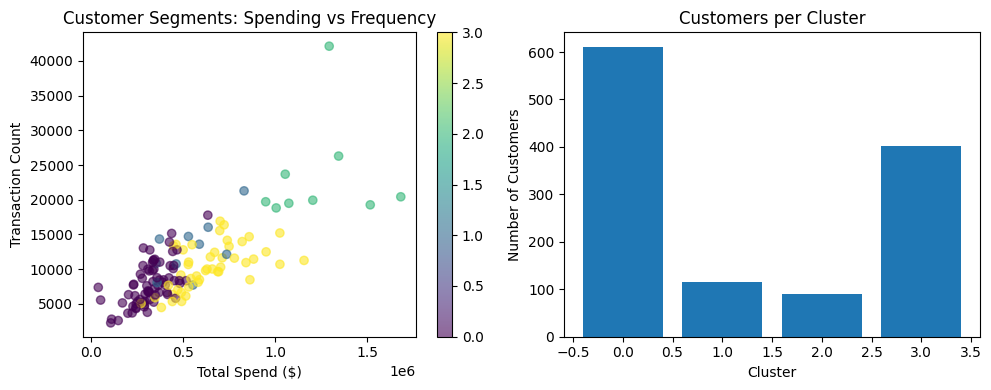

Text(0.5, 1.0, 'Customer Segments: Spending vs Frequency\n(High-value vs High-frequency customers)')

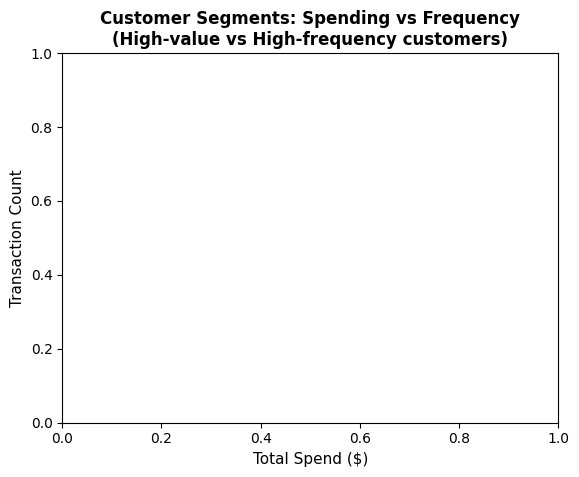

In [ ]:
# Simple cluster visualization
sample_data = predictions.sample(0.1, seed=42).toPandas()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(sample_data['total_spend'], sample_data['transaction_count'], 
           c=sample_data['prediction'], cmap='viridis', alpha=0.6)
plt.xlabel('Total Spend ($)')
plt.ylabel('Transaction Count')
plt.title('Customer Segments: Spending vs Frequency')
plt.colorbar()

plt.subplot(1, 2, 2)
cluster_summary_pd = cluster_summary.toPandas()
plt.bar(cluster_summary_pd['cluster'], cluster_summary_pd['customer_count'])
plt.xlabel('Cluster')
plt.ylabel('Number of Customers') 
plt.title('Customers per Cluster')


## 6. Business Insights  

In [ ]:
# Simple business interpretation
print("Customer Segmentation Results:")
print("=" * 40)

for i, row in cluster_summary.collect():
    cluster_id = row['cluster']
    print(f"\nCluster {cluster_id}: {row['customer_count']:,} customers")
    print(f"  Average spend: ${row['avg_total_spend']:,.2f}")
    print(f"  Online ratio: {row['avg_online_ratio']*100:.1f}%")
    
    # Simple persona assignment
    if row['avg_total_spend'] > 1000:
        persona = "High-Value Customer"
    elif row['avg_online_ratio'] > 0.5:
        persona = "Digital Customer"
    else:
        persona = "Traditional Customer"
    
    print(f"  Persona: {persona}")

print(f"\n✅ Clustering completed! Found meaningful customer segments for targeted marketing.")

# Cleanup
spark.stop()